In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import jit, njit, vectorize
import time

## Defining functions that we need:

In [180]:
#Trial energy 1
def TrialEnergy1(alpha,omega,r1,r2):
    return 0.5*omega**2*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@vectorize#By far the quickest of the three
def TrialEnergy1Vec(alpha,omega,r1,r2):
    #r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    #r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    return 0.5*omega**2*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@jit(nopython=True)
def TrialEnergyJIT(alpha,omega,r1,r2):
    return 0.5*(omega**2)*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@jit
def TrialWaveFunction1(alpha,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    return np.exp(-alpha*omega*(r1**2 + r2**2)/2)

In [198]:
alpha = 2
trialEnergyTemp = TrialEnergyJIT(alpha,1,0,0)
print(trialEnergyTemp)

6.0


## Monte Carlo and Metropolis algo:

In [181]:
#Probability ratio
@jit
def ProbRatio(Rold,Rnew,alpha,omega):#Rold and Rnew as an array
    new = TrialWaveFunction1(alpha,omega,Rnew[0],Rnew[1],Rnew[2],Rnew[3],Rnew[4],Rnew[5])
    new = new**2
    old = TrialWaveFunction1(alpha,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
    old = old**2
    return new/old

#Metropolis part
@jit
def Metropolis(Rold,Rnew,alpha,omega):
    Acceptance = False
    probRatio = ProbRatio(Rold,Rnew,alpha,omega)
    if probRatio > 1:
        Acceptance = True
    elif np.random.random() <= probRatio:
        Acceptance = True
    else:
        Acceptance = False
    return Acceptance

In [156]:
R1 = np.array([1,1,1,1,1,1])
R2 = np.array([2,2,2,2,2,2])
alpha = 1
omega = 1
print(Metropolis(R1,R2,alpha,omega))

a = np.array([1,2,3])
print(a+1)

False
[2 3 4]


In [215]:
#Monte Carlo part
@jit
def MonteCarlo(MCCycles,omega,alpha,stepsize):
    #initalizing position randomly according to exponetial distribution
    x1 = np.random.exponential()
    y1 = np.random.exponential()
    z1 = np.random.exponential()
    x2 = np.random.exponential()
    y2 = np.random.exponential()
    z2 = np.random.exponential()
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    Rold = np.array([x1,y1,z1,x2,y2,z2])
    Energy = TrialEnergy1Vec(alpha,omega,r1,r2)
    #Step size for proposed steps
    DeltaR = stepsize
    #Counter for how many steps are accepted
    CounterAccept = 0
    #looping over MC cycles
    for i in range(MCCycles):
        #looping over each position, in total 6
        for l in range(6):
            randnum = (1+1)*np.random.random() - 1#creating random number on [-1,1]
            Rnew = np.copy(Rold)
            Rnew[l] = Rold[l] + randnum*DeltaR#The proposed move
            #Metropolis test
            Acceptance = Metropolis(Rold,Rnew,alpha,omega)
            if Acceptance:#Moving the coordinates if the move is accepted
                Rold = Rnew
                CounterAccept += 1
        r1 = np.sqrt(Rold[0]**2 + Rold[1]**2 + Rold[2]**2)
        r2 = np.sqrt(Rold[3]**2 + Rold[4]**2 + Rold[5]**2)
        Energy += TrialEnergyJIT(alpha,omega,r1,r2)
    
    print(Rold)
    #End of MC loop
    #Analysis of relevant parameters
    Energy = Energy/MCCycles
    
    return Energy, CounterAccept

## Trial of the MC calculations:

[-1.74872634 -0.29912461 -0.61231354  0.12118551  0.21863077 -1.85958973]
590723
[ 1.87407997 -0.73218858  1.10377795  0.05168521  1.13766867 -1.08490133]
587956
[ 0.63380123  0.85345121  0.40199244  1.4336446   0.49495447 -0.90985139]
586210
[-0.53500205 -0.2342058  -1.07377475 -0.40469112  0.35279411  0.22294874]
583719
[ 0.86551979  0.12412766  1.33442047  0.13630677  0.60543493 -0.9458425 ]
582887
[-0.71330192 -0.6008371  -0.66261478  0.18046028  0.6003133   0.34866566]
581385
[-0.2667077  -0.42074608  0.38417469 -0.43780586  0.26368512  0.81785873]
579810
[-0.53192131  1.23396392 -0.45749638 -0.34440396 -0.16131014 -0.12875413]
578341
[ 0.24978141 -0.40658654  0.03080377  0.27061134 -0.2719942   0.50220666]
577801
[-0.23437116 -0.38379022  0.84513927 -0.17043381  0.12887356  0.58836382]
576221


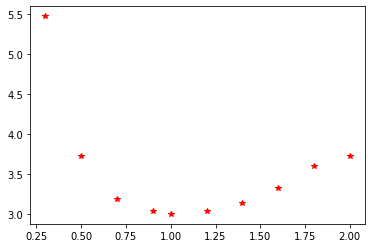

In [217]:
alpha = [0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8,2.0]
fig, ax = plt.subplots()
for alphaTemp in alpha:
    Energy, Counter = MonteCarlo(100000,1,alphaTemp,0.1)
    print(Counter)
    ax.plot(alphaTemp,Energy,'r*')